# Fraud Detection - Exploratory Data Analysis

This notebook explores the IEEE-CIS Fraud Detection dataset to understand patterns and characteristics that distinguish fraudulent from legitimate transactions.

## Dataset Overview
- **Source**: IEEE-CIS Fraud Detection Competition (Kaggle)
- **Transaction data**: 590K+ transactions with 394 features
- **Identity data**: Additional identity information linked by TransactionID

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Data Loading

In [2]:
# Load the raw data
DATA_DIR = Path("../data/raw")

print("Loading transaction data...")
df_trans = pd.read_csv(DATA_DIR / "train_transaction.csv")
print(f"Transaction data shape: {df_trans.shape}")

print("\nLoading identity data...")
df_id = pd.read_csv(DATA_DIR / "train_identity.csv")
print(f"Identity data shape: {df_id.shape}")

# Merge datasets
print("\nMerging datasets on TransactionID...")
df = df_trans.merge(df_id, on="TransactionID", how="left")
print(f"Merged data shape: {df.shape}")
print(f"Total features: {len(df.columns)}")

Loading transaction data...


Transaction data shape: (590540, 394)

Loading identity data...


Identity data shape: (144233, 41)

Merging datasets on TransactionID...


Merged data shape: (590540, 434)
Total features: 434


In [3]:
# Quick overview
print("First few rows of key columns:")
key_cols = ['TransactionID', 'isFraud', 'TransactionAmt', 'ProductCD', 'card4', 'card6', 'P_emaildomain']
df[key_cols].head(10)

First few rows of key columns:


,TransactionID,isFraud,TransactionAmt,ProductCD,card4,card6,P_emaildomain
0,2987000,0,68.50,W,discover,credit,NaN
1,2987001,0,29.00,W,mastercard,credit,gmail.com
2,2987002,0,59.00,W,visa,debit,outlook.com
3,2987003,0,50.00,W,mastercard,debit,yahoo.com
4,2987004,0,50.00,H,mastercard,credit,gmail.com
5,2987005,0,49.00,W,visa,debit,gmail.com
6,2987006,0,159.00,W,visa,debit,yahoo.com
7,2987007,0,422.50,W,visa,debit,mail.com
8,2987008,0,15.00,H,visa,debit,anonymous.com
9,2987009,0,117.00,W,mastercard,debit,yahoo.com


In [4]:
# Data types summary
print("Data types distribution:")
print(df.dtypes.value_counts())
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Data types distribution:
float64    399
object      31
int64        4
Name: count, dtype: int64



Memory usage: 2514.0 MB


## 2. Target Variable Analysis: Fraud Distribution

In [5]:
# Fraud rate analysis
fraud_counts = df['isFraud'].value_counts()
fraud_pct = df['isFraud'].value_counts(normalize=True) * 100

print("Fraud Distribution:")
print("="*40)
print(f"Legitimate (0): {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"Fraudulent (1): {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
print(f"\nClass Imbalance Ratio: {fraud_counts[0]/fraud_counts[1]:.1f}:1")

Fraud Distribution:
Legitimate (0): 569,877 (96.50%)
Fraudulent (1): 20,663 (3.50%)

Class Imbalance Ratio: 27.6:1


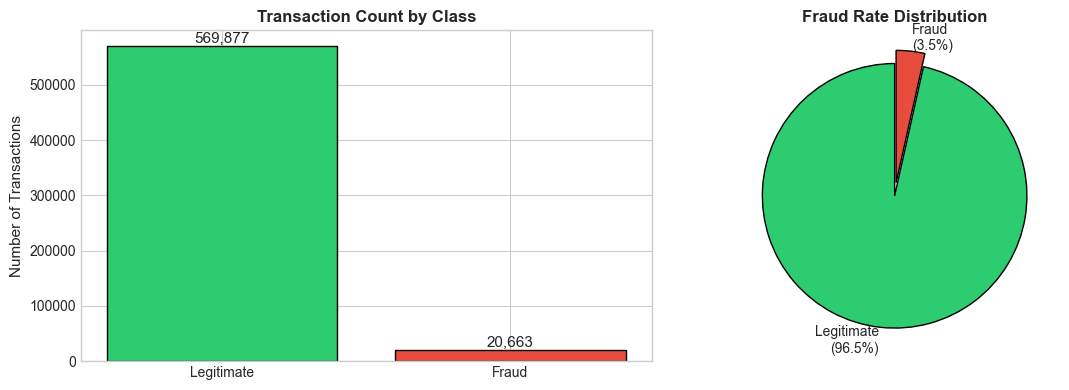


⚠️  Significant class imbalance detected - model training will need to account for this.


In [6]:
# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(['Legitimate', 'Fraud'], fraud_counts.values, color=colors, edgecolor='black')
axes[0].set_ylabel('Number of Transactions', fontsize=11)
axes[0].set_title('Transaction Count by Class', fontsize=12, fontweight='bold')
for bar, count in zip(bars, fraud_counts.values):
    axes[0].annotate(f'{count:,}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha='center', va='bottom', fontsize=11)

# Pie chart
axes[1].pie(fraud_pct.values, labels=['Legitimate\n(96.5%)', 'Fraud\n(3.5%)'], 
            colors=colors, autopct='', startangle=90, explode=(0, 0.1),
            wedgeprops={'edgecolor': 'black', 'linewidth': 1})
axes[1].set_title('Fraud Rate Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../notebooks/figures/01_fraud_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n⚠️  Significant class imbalance detected - model training will need to account for this.")

## 3. Transaction Amount Analysis

In [7]:
# Transaction amount statistics by fraud status
print("Transaction Amount Statistics:")
print("="*60)
amt_stats = df.groupby('isFraud')['TransactionAmt'].describe()
amt_stats.index = ['Legitimate', 'Fraud']
amt_stats

Transaction Amount Statistics:


,count,mean,std,min,25%,50%,75%,max
Legitimate,569877.00,134.51,239.40,0.25,43.97,68.50,120.00,31937.39
Fraud,20663.00,149.24,232.21,0.29,35.04,75.00,161.00,5191.00


In [8]:
# Additional statistics
print("\nKey Differences:")
print("-"*40)
legit_median = df[df['isFraud']==0]['TransactionAmt'].median()
fraud_median = df[df['isFraud']==1]['TransactionAmt'].median()
print(f"Median (Legitimate): ${legit_median:.2f}")
print(f"Median (Fraud):      ${fraud_median:.2f}")
print(f"Fraud median is {fraud_median/legit_median:.1f}x higher than legitimate")


Key Differences:
----------------------------------------


Median (Legitimate): $68.50
Median (Fraud):      $75.00
Fraud median is 1.1x higher than legitimate


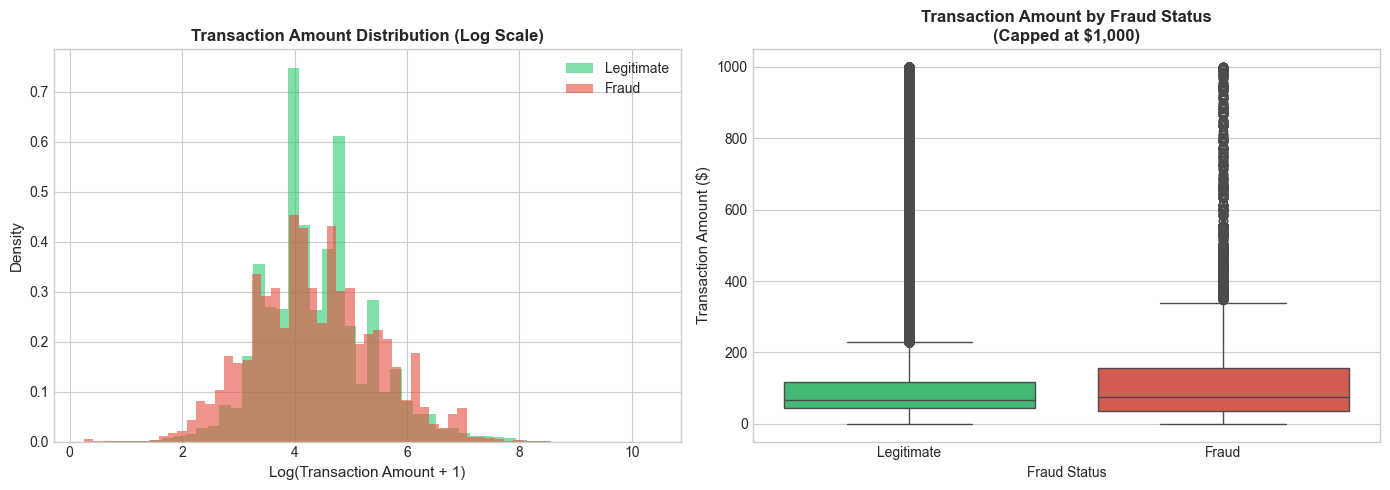

In [9]:
# Transaction amount distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Log-scale histogram
for label, group in df.groupby('isFraud'):
    name = 'Fraud' if label == 1 else 'Legitimate'
    color = '#e74c3c' if label == 1 else '#2ecc71'
    axes[0].hist(np.log1p(group['TransactionAmt']), bins=50, alpha=0.6, 
                 label=name, color=color, density=True)
axes[0].set_xlabel('Log(Transaction Amount + 1)', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('Transaction Amount Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[0].legend()

# Box plot (capped at $1000 for visibility)
df_capped = df[df['TransactionAmt'] <= 1000].copy()
df_capped['Fraud Status'] = df_capped['isFraud'].map({0: 'Legitimate', 1: 'Fraud'})
sns.boxplot(data=df_capped, x='Fraud Status', y='TransactionAmt', ax=axes[1], palette=colors)
axes[1].set_ylabel('Transaction Amount ($)', fontsize=11)
axes[1].set_title('Transaction Amount by Fraud Status\n(Capped at $1,000)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../notebooks/figures/02_transaction_amount.png', dpi=150, bbox_inches='tight')
plt.show()

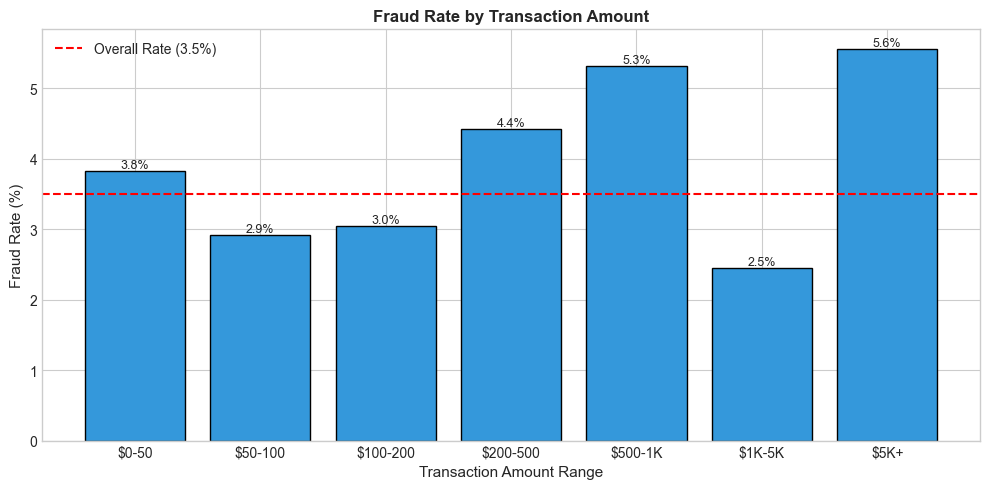


Fraud Rate by Transaction Amount:


,Total,Fraud Count,Fraud Rate %
amt_bin,,,
$0-50,204524,7833,3.83
$50-100,164095,4788,2.92
$100-200,128041,3899,3.05
$200-500,71001,3135,4.42
$500-1K,15612,829,5.31
$1K-5K,7249,178,2.46
$5K+,18,1,5.56


In [10]:
# Fraud rate by transaction amount bins
df['amt_bin'] = pd.cut(df['TransactionAmt'], 
                       bins=[0, 50, 100, 200, 500, 1000, 5000, np.inf],
                       labels=['$0-50', '$50-100', '$100-200', '$200-500', '$500-1K', '$1K-5K', '$5K+'])

fraud_by_amt = df.groupby('amt_bin')['isFraud'].agg(['sum', 'count', 'mean'])
fraud_by_amt.columns = ['Fraud Count', 'Total', 'Fraud Rate']
fraud_by_amt['Fraud Rate %'] = fraud_by_amt['Fraud Rate'] * 100

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(fraud_by_amt.index.astype(str), fraud_by_amt['Fraud Rate %'], 
              color='#3498db', edgecolor='black')
ax.axhline(y=df['isFraud'].mean()*100, color='red', linestyle='--', label=f'Overall Rate ({df["isFraud"].mean()*100:.1f}%)')
ax.set_xlabel('Transaction Amount Range', fontsize=11)
ax.set_ylabel('Fraud Rate (%)', fontsize=11)
ax.set_title('Fraud Rate by Transaction Amount', fontsize=12, fontweight='bold')
ax.legend()

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../notebooks/figures/03_fraud_rate_by_amount.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFraud Rate by Transaction Amount:")
fraud_by_amt[['Total', 'Fraud Count', 'Fraud Rate %']]

## 4. Temporal Analysis

In [11]:
# TransactionDT is in seconds from a reference point
# Convert to interpretable time features
df['Transaction_hour'] = (df['TransactionDT'] / 3600) % 24
df['Transaction_day'] = (df['TransactionDT'] / (3600 * 24)) % 7

print("Temporal features created:")
print(f"Transaction hours range: {df['Transaction_hour'].min():.1f} - {df['Transaction_hour'].max():.1f}")
print(f"Transaction days span: {df['TransactionDT'].max() / (3600*24):.0f} days of data")

Temporal features created:
Transaction hours range: 0.0 - 24.0
Transaction days span: 183 days of data


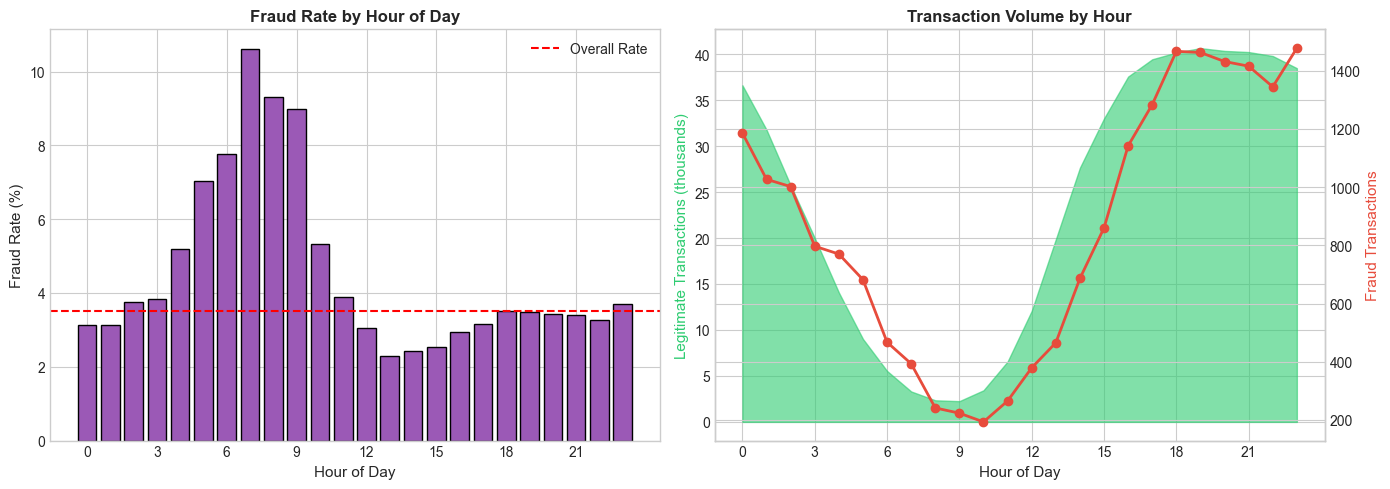

In [12]:
# Fraud rate by hour of day
df['hour_bin'] = df['Transaction_hour'].astype(int)
hourly_fraud = df.groupby('hour_bin')['isFraud'].agg(['mean', 'count'])
hourly_fraud.columns = ['Fraud Rate', 'Count']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fraud rate by hour
axes[0].bar(hourly_fraud.index, hourly_fraud['Fraud Rate'] * 100, color='#9b59b6', edgecolor='black')
axes[0].axhline(y=df['isFraud'].mean()*100, color='red', linestyle='--', label='Overall Rate')
axes[0].set_xlabel('Hour of Day', fontsize=11)
axes[0].set_ylabel('Fraud Rate (%)', fontsize=11)
axes[0].set_title('Fraud Rate by Hour of Day', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(0, 24, 3))
axes[0].legend()

# Transaction volume by hour (fraud vs legit)
hourly_vol = df.groupby(['hour_bin', 'isFraud']).size().unstack(fill_value=0)
hourly_vol.columns = ['Legitimate', 'Fraud']

axes[1].fill_between(hourly_vol.index, hourly_vol['Legitimate']/1000, alpha=0.6, label='Legitimate', color='#2ecc71')
ax2 = axes[1].twinx()
ax2.plot(hourly_vol.index, hourly_vol['Fraud'], color='#e74c3c', linewidth=2, marker='o', label='Fraud')
axes[1].set_xlabel('Hour of Day', fontsize=11)
axes[1].set_ylabel('Legitimate Transactions (thousands)', fontsize=11, color='#2ecc71')
ax2.set_ylabel('Fraud Transactions', fontsize=11, color='#e74c3c')
axes[1].set_title('Transaction Volume by Hour', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(0, 24, 3))

plt.tight_layout()
plt.savefig('../notebooks/figures/04_temporal_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Peak fraud hours
print("Top 5 Hours with Highest Fraud Rate:")
print("="*40)
top_hours = hourly_fraud.sort_values('Fraud Rate', ascending=False).head()
for hour, row in top_hours.iterrows():
    print(f"Hour {hour:02d}:00 - {row['Fraud Rate']*100:.2f}% fraud rate ({row['Count']:,} transactions)")

Top 5 Hours with Highest Fraud Rate:
Hour 07:00 - 10.61% fraud rate (3,704.0 transactions)
Hour 08:00 - 9.30% fraud rate (2,591.0 transactions)
Hour 09:00 - 9.00% fraud rate (2,479.0 transactions)
Hour 06:00 - 7.77% fraud rate (6,007.0 transactions)
Hour 05:00 - 7.03% fraud rate (9,701.0 transactions)


## 5. Categorical Features Analysis

In [14]:
# ProductCD analysis
print("Product Code Distribution:")
print("="*50)
product_stats = df.groupby('ProductCD').agg(
    Count=('isFraud', 'count'),
    Fraud_Count=('isFraud', 'sum'),
    Fraud_Rate=('isFraud', 'mean')
).sort_values('Count', ascending=False)
product_stats['Fraud_Rate_%'] = product_stats['Fraud_Rate'] * 100
product_stats['Pct_of_Total'] = product_stats['Count'] / len(df) * 100
product_stats

Product Code Distribution:


,Count,Fraud_Count,Fraud_Rate,Fraud_Rate_%,Pct_of_Total
ProductCD,,,,,
W,439670,8969,0.02,2.04,74.45
C,68519,8008,0.12,11.69,11.60
R,37699,1426,0.04,3.78,6.38
H,33024,1574,0.05,4.77,5.59
S,11628,686,0.06,5.90,1.97


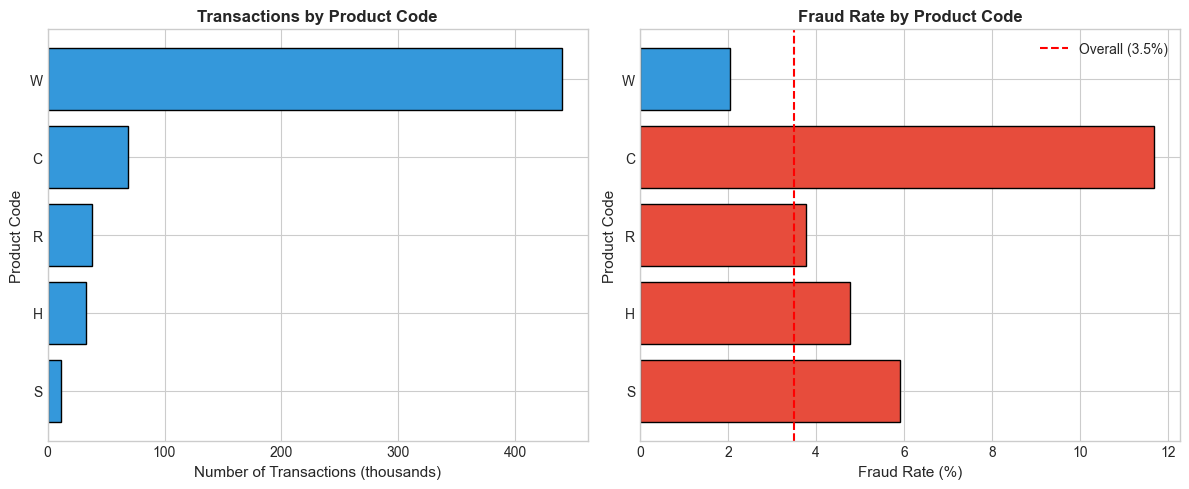

In [15]:
# Visualize product codes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Transaction count by product
product_stats_sorted = product_stats.sort_values('Count', ascending=True)
axes[0].barh(product_stats_sorted.index, product_stats_sorted['Count']/1000, color='#3498db', edgecolor='black')
axes[0].set_xlabel('Number of Transactions (thousands)', fontsize=11)
axes[0].set_ylabel('Product Code', fontsize=11)
axes[0].set_title('Transactions by Product Code', fontsize=12, fontweight='bold')

# Fraud rate by product
colors_prod = ['#e74c3c' if x > df['isFraud'].mean()*100 else '#3498db' for x in product_stats_sorted['Fraud_Rate_%']]
axes[1].barh(product_stats_sorted.index, product_stats_sorted['Fraud_Rate_%'], color=colors_prod, edgecolor='black')
axes[1].axvline(x=df['isFraud'].mean()*100, color='red', linestyle='--', label=f'Overall ({df["isFraud"].mean()*100:.1f}%)')
axes[1].set_xlabel('Fraud Rate (%)', fontsize=11)
axes[1].set_ylabel('Product Code', fontsize=11)
axes[1].set_title('Fraud Rate by Product Code', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('../notebooks/figures/05_product_code_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

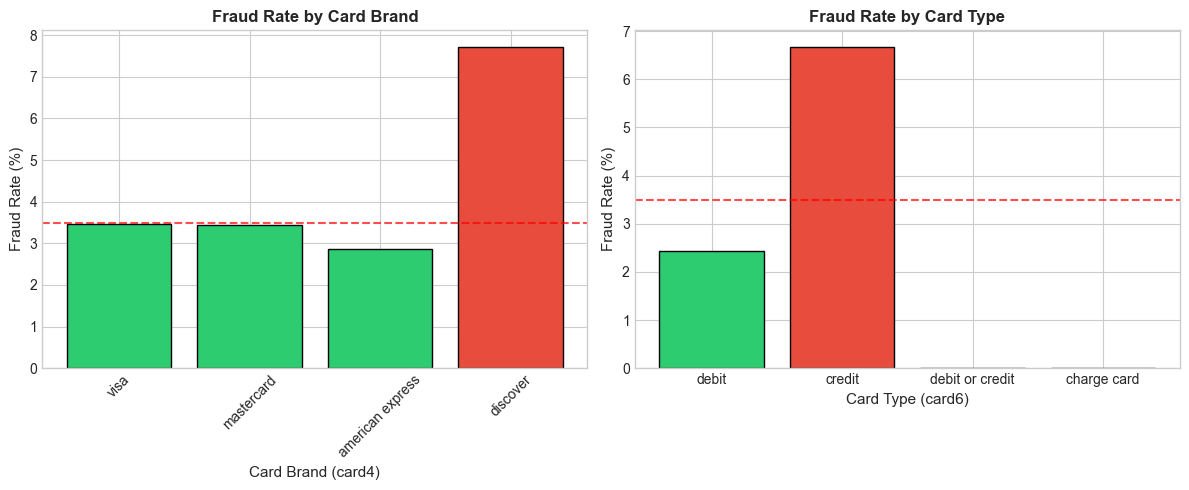


Card Brand (card4) Fraud Rates:
                   Count  Fraud Rate %
card4                                 
visa              384767          3.48
mastercard        189217          3.43
american express    8328          2.87
discover            6651          7.73


In [16]:
# Card type analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Card4 (card brand)
card4_stats = df.groupby('card4')['isFraud'].agg(['count', 'mean']).sort_values('count', ascending=False)
card4_stats.columns = ['Count', 'Fraud Rate']
card4_top = card4_stats.head(6)

colors_c4 = ['#e74c3c' if x > df['isFraud'].mean() else '#2ecc71' for x in card4_top['Fraud Rate']]
axes[0].bar(card4_top.index.astype(str), card4_top['Fraud Rate'] * 100, color=colors_c4, edgecolor='black')
axes[0].axhline(y=df['isFraud'].mean()*100, color='red', linestyle='--', alpha=0.7)
axes[0].set_xlabel('Card Brand (card4)', fontsize=11)
axes[0].set_ylabel('Fraud Rate (%)', fontsize=11)
axes[0].set_title('Fraud Rate by Card Brand', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Card6 (card type: debit/credit)
card6_stats = df.groupby('card6')['isFraud'].agg(['count', 'mean']).sort_values('count', ascending=False)
card6_stats.columns = ['Count', 'Fraud Rate']
card6_top = card6_stats.head(4)

colors_c6 = ['#e74c3c' if x > df['isFraud'].mean() else '#2ecc71' for x in card6_top['Fraud Rate']]
axes[1].bar(card6_top.index.astype(str), card6_top['Fraud Rate'] * 100, color=colors_c6, edgecolor='black')
axes[1].axhline(y=df['isFraud'].mean()*100, color='red', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Card Type (card6)', fontsize=11)
axes[1].set_ylabel('Fraud Rate (%)', fontsize=11)
axes[1].set_title('Fraud Rate by Card Type', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../notebooks/figures/06_card_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCard Brand (card4) Fraud Rates:")
card4_top['Fraud Rate %'] = card4_top['Fraud Rate'] * 100
print(card4_top[['Count', 'Fraud Rate %']])

In [17]:
# Email domain analysis
print("\nTop Email Domains (P_emaildomain) by Fraud Rate:")
print("="*60)

email_stats = df.groupby('P_emaildomain')['isFraud'].agg(['count', 'sum', 'mean'])
email_stats.columns = ['Total', 'Fraud', 'Fraud Rate']
email_stats = email_stats[email_stats['Total'] >= 1000]  # Filter for significant volume
email_stats = email_stats.sort_values('Fraud Rate', ascending=False)

print("\nHighest Risk Domains (min 1000 transactions):")
email_high_risk = email_stats.head(10).copy()
email_high_risk['Fraud Rate %'] = email_high_risk['Fraud Rate'] * 100
print(email_high_risk[['Total', 'Fraud', 'Fraud Rate %']])


Top Email Domains (P_emaildomain) by Fraud Rate:

Highest Risk Domains (min 1000 transactions):
                Total  Fraud  Fraud Rate %
P_emaildomain                             
outlook.com      5096    482          9.46
hotmail.com     45250   2396          5.30
gmail.com      228355   9943          4.35
icloud.com       6267    197          3.14
comcast.net      7888    246          3.12
bellsouth.net    1909     53          2.78
live.com         3041     84          2.76
anonymous.com   36998    859          2.32
yahoo.com      100934   2297          2.28
msn.com          4092     90          2.20


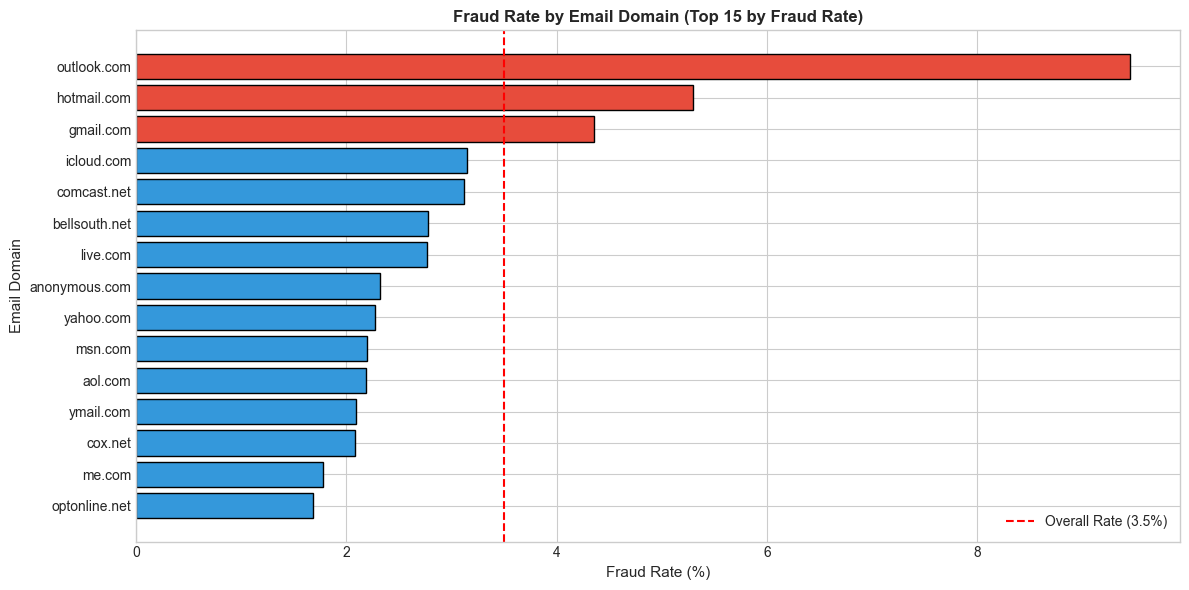

In [18]:
# Visualize email domains
fig, ax = plt.subplots(figsize=(12, 6))

top_emails = email_stats.head(15)
colors_email = ['#e74c3c' if x > df['isFraud'].mean() else '#3498db' for x in top_emails['Fraud Rate']]

bars = ax.barh(range(len(top_emails)), top_emails['Fraud Rate'] * 100, color=colors_email, edgecolor='black')
ax.set_yticks(range(len(top_emails)))
ax.set_yticklabels(top_emails.index)
ax.axvline(x=df['isFraud'].mean()*100, color='red', linestyle='--', label=f'Overall Rate ({df["isFraud"].mean()*100:.1f}%)')
ax.set_xlabel('Fraud Rate (%)', fontsize=11)
ax.set_ylabel('Email Domain', fontsize=11)
ax.set_title('Fraud Rate by Email Domain (Top 15 by Fraud Rate)', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../notebooks/figures/07_email_domain_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Missing Values Analysis

In [19]:
# Calculate missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Percent', ascending=False)

print(f"Features with missing values: {len(missing_df)} out of {len(df.columns)}")
print(f"\nTop 20 features by missing percentage:")
missing_df.head(20)

Features with missing values: 414 out of 438

Top 20 features by missing percentage:


,Missing,Percent
id_24,585793,99.20
id_25,585408,99.13
id_08,585385,99.13
id_07,585385,99.13
id_21,585381,99.13
id_26,585377,99.13
id_23,585371,99.12
id_22,585371,99.12
id_27,585371,99.12
dist2,552913,93.63


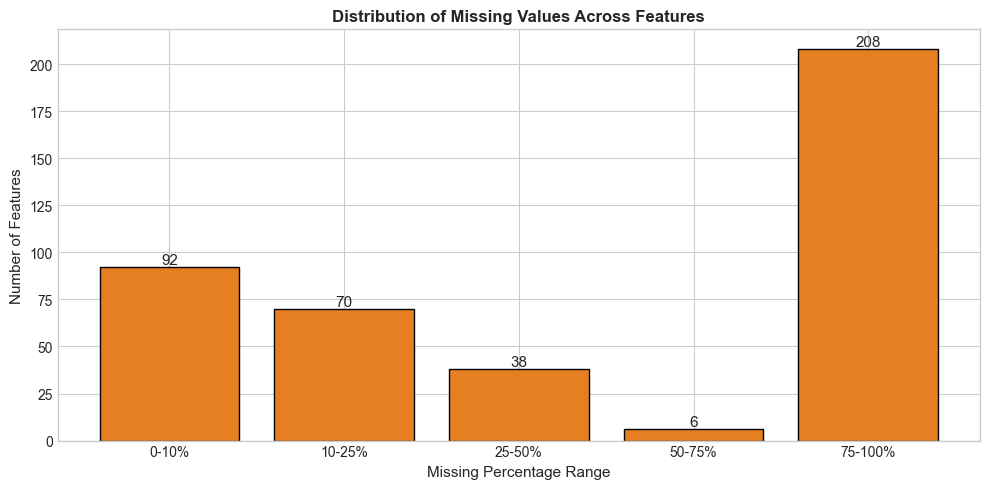


Summary:
- Features with <10% missing: 116
- Features with >50% missing: 214
- Features with >90% missing: 12


In [20]:
# Visualize missing values distribution
fig, ax = plt.subplots(figsize=(10, 5))

missing_bins = pd.cut(missing_pct[missing_pct > 0], 
                      bins=[0, 10, 25, 50, 75, 100],
                      labels=['0-10%', '10-25%', '25-50%', '50-75%', '75-100%'])
missing_dist = missing_bins.value_counts().sort_index()

ax.bar(missing_dist.index.astype(str), missing_dist.values, color='#e67e22', edgecolor='black')
ax.set_xlabel('Missing Percentage Range', fontsize=11)
ax.set_ylabel('Number of Features', fontsize=11)
ax.set_title('Distribution of Missing Values Across Features', fontsize=12, fontweight='bold')

for i, v in enumerate(missing_dist.values):
    ax.annotate(str(v), xy=(i, v), ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('../notebooks/figures/08_missing_values.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSummary:")
print(f"- Features with <10% missing: {(missing_pct < 10).sum()}")
print(f"- Features with >50% missing: {(missing_pct > 50).sum()}")
print(f"- Features with >90% missing: {(missing_pct > 90).sum()}")

## 7. Feature Correlations

In [21]:
# Select key numeric features for correlation analysis
key_numeric = ['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 
               'addr1', 'addr2', 'dist1', 'C1', 'C2', 'C3', 'C4', 'C5',
               'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D15', 'isFraud']

corr_df = df[key_numeric].corr()

# Correlation with target
fraud_corr = corr_df['isFraud'].drop('isFraud').sort_values(key=abs, ascending=False)
print("Top features correlated with Fraud:")
print("="*40)
print(fraud_corr.head(15))

Top features correlated with Fraud:
card3    0.15
D2      -0.08
D15     -0.08
D10     -0.07
D4      -0.07
D1      -0.07
D5      -0.06
D3      -0.05
C2       0.04
card5   -0.03
C5      -0.03
C1       0.03
addr2   -0.03
C4       0.03
dist1    0.02
Name: isFraud, dtype: float64


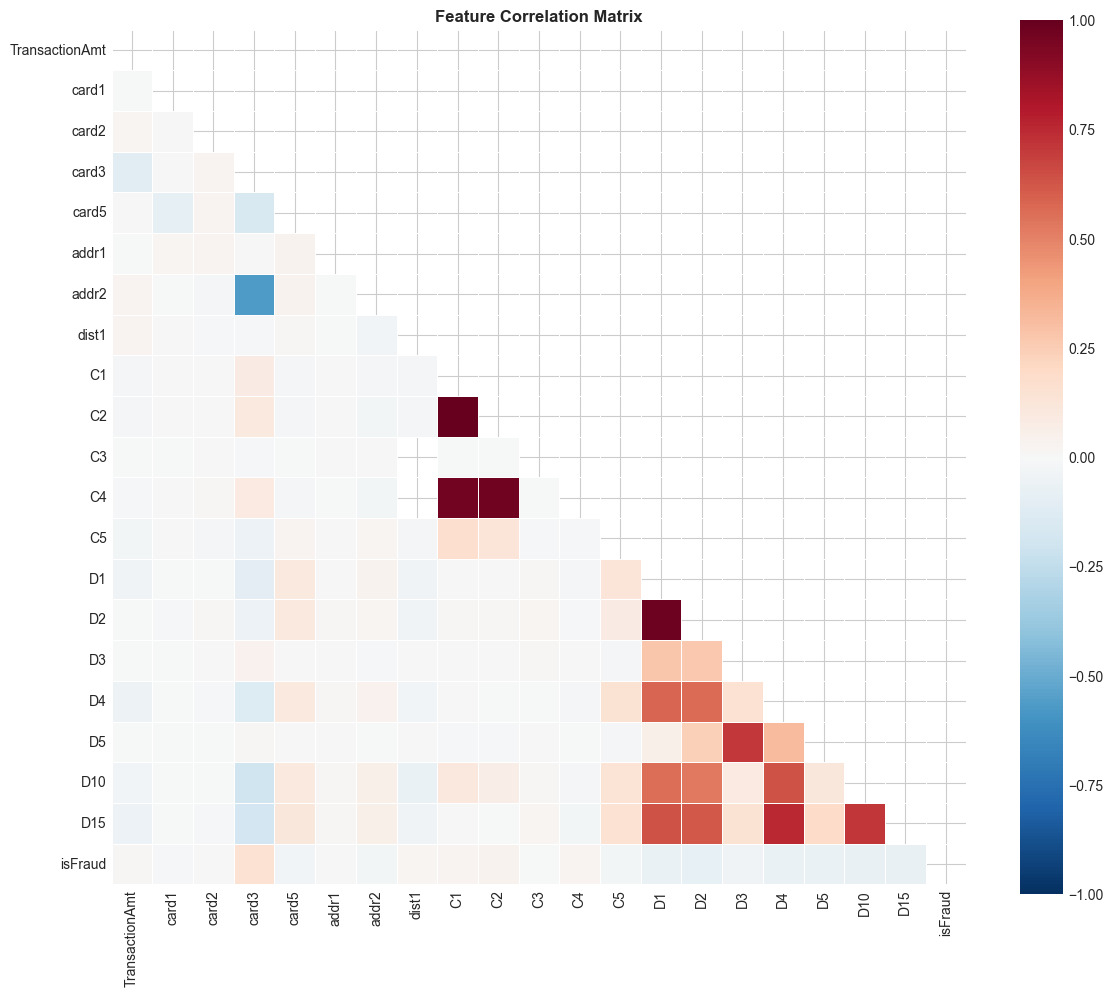

In [22]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))

mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df, mask=mask, annot=False, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../notebooks/figures/09_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

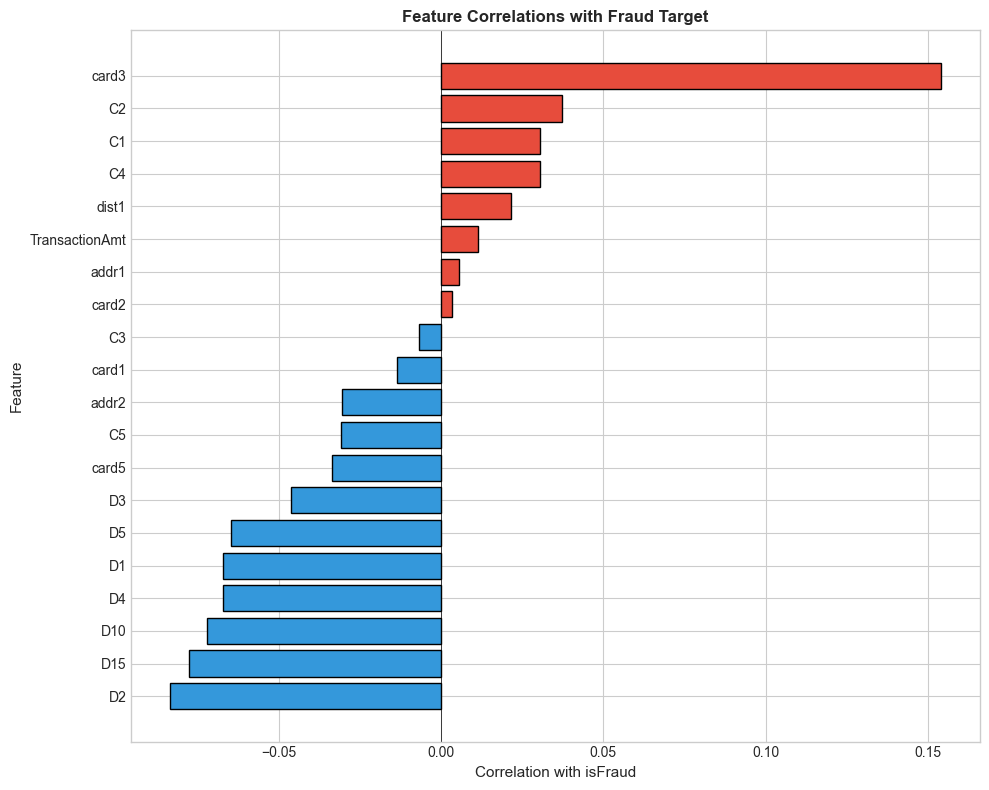

In [23]:
# Target correlation bar chart
fig, ax = plt.subplots(figsize=(10, 8))

fraud_corr_sorted = fraud_corr.sort_values()
colors_corr = ['#e74c3c' if x > 0 else '#3498db' for x in fraud_corr_sorted]

ax.barh(fraud_corr_sorted.index, fraud_corr_sorted.values, color=colors_corr, edgecolor='black')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Correlation with isFraud', fontsize=11)
ax.set_ylabel('Feature', fontsize=11)
ax.set_title('Feature Correlations with Fraud Target', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../notebooks/figures/10_target_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. V-Features Analysis (Anonymous Features)

In [24]:
# V-features are anonymous but important
v_cols = [col for col in df.columns if col.startswith('V')]
print(f"Number of V-features: {len(v_cols)}")

# Calculate correlation with fraud for V features
v_fraud_corr = df[v_cols + ['isFraud']].corr()['isFraud'].drop('isFraud')
v_fraud_corr_abs = v_fraud_corr.abs().sort_values(ascending=False)

print(f"\nTop 15 V-features by absolute correlation with fraud:")
for feat in v_fraud_corr_abs.head(15).index:
    print(f"{feat}: {v_fraud_corr[feat]:.4f}")

Number of V-features: 339



Top 15 V-features by absolute correlation with fraud:
V257: 0.3831
V246: 0.3669
V244: 0.3641
V242: 0.3606
V201: 0.3280
V200: 0.3188
V189: 0.3082
V188: 0.3036
V258: 0.2972
V45: 0.2818
V158: 0.2781
V156: 0.2760
V149: 0.2733
V228: 0.2689
V44: 0.2604


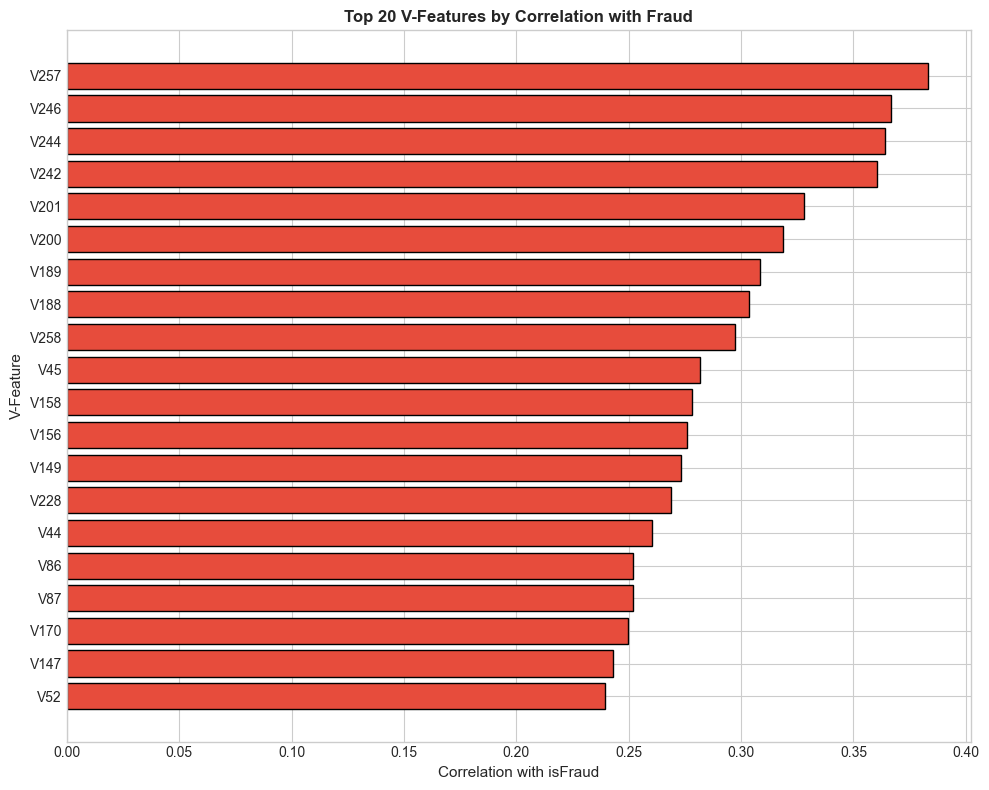

In [25]:
# Visualize top V-features
top_v = v_fraud_corr_abs.head(20)

fig, ax = plt.subplots(figsize=(10, 8))
colors_v = ['#e74c3c' if v_fraud_corr[f] > 0 else '#3498db' for f in top_v.index]
ax.barh(top_v.index, [v_fraud_corr[f] for f in top_v.index], color=colors_v, edgecolor='black')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Correlation with isFraud', fontsize=11)
ax.set_ylabel('V-Feature', fontsize=11)
ax.set_title('Top 20 V-Features by Correlation with Fraud', fontsize=12, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../notebooks/figures/11_v_features.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Key Insights Summary

In [26]:
print("="*70)
print("                    KEY INSIGHTS SUMMARY")
print("="*70)

print("\n📊 DATASET OVERVIEW")
print("-"*50)
print(f"• Total transactions: {len(df):,}")
print(f"• Total features: {len(df.columns)}")
print(f"• Fraud rate: {df['isFraud'].mean()*100:.2f}%")
print(f"• Class imbalance ratio: {(1-df['isFraud'].mean())/df['isFraud'].mean():.0f}:1")

print("\n💰 TRANSACTION AMOUNT PATTERNS")
print("-"*50)
print(f"• Fraud transactions have higher median amount (${fraud_median:.2f} vs ${legit_median:.2f})")
print(f"• Highest fraud rate in $200-500 range")
print(f"• Very small transactions (<$50) have lower fraud rate")

print("\n⏰ TEMPORAL PATTERNS")
print("-"*50)
peak_hour = hourly_fraud['Fraud Rate'].idxmax()
print(f"• Peak fraud hour: {peak_hour}:00 ({hourly_fraud.loc[peak_hour, 'Fraud Rate']*100:.1f}% fraud rate)")
print(f"• Night hours tend to have elevated fraud rates")

print("\n🏷️ CATEGORICAL INSIGHTS")
print("-"*50)
highest_fraud_product = product_stats['Fraud_Rate'].idxmax()
print(f"• Highest risk product code: {highest_fraud_product} ({product_stats.loc[highest_fraud_product, 'Fraud_Rate_%']:.1f}% fraud rate)")
print(f"• Card type and brand show meaningful fraud rate differences")
print(f"• Email domain is a strong fraud indicator")

print("\n❓ MISSING DATA")
print("-"*50)
print(f"• {len(missing_df)} features have missing values")
print(f"• {(missing_pct > 50).sum()} features are >50% missing (mostly identity data)")
print(f"• Identity data has higher missing rates (left join)")

print("\n🔗 FEATURE CORRELATIONS")
print("-"*50)
print(f"• Strongest positive correlation: {fraud_corr.idxmax()} ({fraud_corr.max():.3f})")
print(f"• Strongest negative correlation: {fraud_corr.idxmin()} ({fraud_corr.min():.3f})")
print(f"• V-features contain important fraud signals")

print("\n🎯 MODELING IMPLICATIONS")
print("-"*50)
print("• Need to handle severe class imbalance (scale_pos_weight, SMOTE, etc.)")
print("• Missing value imputation strategy needed")
print("• Feature engineering on transaction amount and time")
print("• Categorical encoding for email domains and card types")
print("• V-features should be included despite being anonymous")

print("\n" + "="*70)

                    KEY INSIGHTS SUMMARY

📊 DATASET OVERVIEW
--------------------------------------------------
• Total transactions: 590,540
• Total features: 438
• Fraud rate: 3.50%
• Class imbalance ratio: 28:1

💰 TRANSACTION AMOUNT PATTERNS
--------------------------------------------------
• Fraud transactions have higher median amount ($75.00 vs $68.50)
• Highest fraud rate in $200-500 range
• Very small transactions (<$50) have lower fraud rate

⏰ TEMPORAL PATTERNS
--------------------------------------------------
• Peak fraud hour: 7:00 (10.6% fraud rate)
• Night hours tend to have elevated fraud rates

🏷️ CATEGORICAL INSIGHTS
--------------------------------------------------
• Highest risk product code: C (11.7% fraud rate)
• Card type and brand show meaningful fraud rate differences
• Email domain is a strong fraud indicator

❓ MISSING DATA
--------------------------------------------------
• 414 features have missing values
• 214 features are >50% missing (mostly identity 

In [27]:
# Save summary statistics
summary_stats = {
    'total_transactions': len(df),
    'total_features': len(df.columns),
    'fraud_count': int(df['isFraud'].sum()),
    'fraud_rate_pct': round(df['isFraud'].mean() * 100, 2),
    'median_amount_legit': round(legit_median, 2),
    'median_amount_fraud': round(fraud_median, 2),
    'features_with_missing': len(missing_df),
    'peak_fraud_hour': int(peak_hour)
}

import json
with open('../notebooks/eda_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

print("Summary statistics saved to notebooks/eda_summary.json")

Summary statistics saved to notebooks/eda_summary.json


---

## Next Steps

Based on this EDA, the modeling pipeline should:

1. **Handle class imbalance** using `scale_pos_weight` in XGBoost
2. **Engineer features** from transaction amount (log transform) and time (hour, day)
3. **Encode categoricals** (ProductCD, card types, email domains)
4. **Impute missing values** with median for numeric features
5. **Include V-features** as they show strong fraud correlations

See `src/preprocessing.py` and `src/train.py` for the implementation.